# Classification - Double-down vs Hit vs Stay 

This notebook is for model building of the classification model to predict what is the best action to take next.

<u>***Setup***</u>

In [1]:
import os,copy
import sqlite3 as sql
import numpy as np

import pandas as pd
from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt

import torch as tc
from torch.utils.data.sampler import SubsetRandomSampler
import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix

## Pulling data

This is simply to connect to the db and pull the data to see what it looks like

In [2]:
# Specify the absolute path to the database file
db_file_path = '../data/game_state.db'

# Check if the database file exists
if os.path.exists(db_file_path):
    conn = sql.connect(db_file_path)
    hitstay_df = pd.read_sql_query('SELECT * FROM players_hitStay', conn)
else:
    print("Database file not found.")


In [3]:
print(f"{hitstay_df.shape=}")
hitstay_df.tail(10)

hitstay_df.shape=(603, 14)


,game_ID,roundNumber,player_name,player_is_pc,round_initial_bet,player_bet,game_pot,player_cards,player_hand,player_bust,house_name,house_visible_card,house_visible_hand,player_choice
593,ef3fcaec-9ee0-4ddf-984e-8cbebedbfbe4,4,House,0,75.0,0.0,237,"(Cl 3,Di K,Di 2,Hr 4)",19,0,House,Hr 4,4,stay
594,828dba19-480b-440e-a7f4-ef1a70523ce3,0,Joe,0,50.0,50.0,50,"(Di Q,Sp A)",21,0,House,Hr 3,3,stay
595,828dba19-480b-440e-a7f4-ef1a70523ce3,0,Albert,0,50.0,50.0,100,"(Cl 4,Sp 4)",8,0,House,Hr 3,3,hit
596,828dba19-480b-440e-a7f4-ef1a70523ce3,0,Albert,0,50.0,50.0,100,"(Cl 4,Sp 4,Cl 7)",15,0,House,Hr 3,3,hit
597,828dba19-480b-440e-a7f4-ef1a70523ce3,0,Albert,0,50.0,50.0,100,"(Cl 4,Sp 4,Cl 7,Hr K)",25,1,House,Hr 3,3,bust
598,828dba19-480b-440e-a7f4-ef1a70523ce3,0,PC-1,1,50.0,50.0,150,"(Cl 5,Hr 2)",7,0,House,Hr 3,3,hit
599,828dba19-480b-440e-a7f4-ef1a70523ce3,0,PC-1,1,50.0,50.0,150,"(Cl 5,Hr 2,Di A)",18,0,House,Hr 3,3,stay
600,828dba19-480b-440e-a7f4-ef1a70523ce3,0,House,0,50.0,0.0,150,"(Sp 2,Hr 3)",5,0,House,Hr 3,3,hit
601,828dba19-480b-440e-a7f4-ef1a70523ce3,0,House,0,50.0,0.0,150,"(Sp 2,Hr 3,Hr J)",15,0,House,Hr J,10,hit
602,828dba19-480b-440e-a7f4-ef1a70523ce3,0,House,0,50.0,0.0,150,"(Sp 2,Hr 3,Hr J,Sp 10)",25,1,House,Sp 10,10,bust


## Analysis

Here is a quick EDA to see what the lay of the land is in the data

In [4]:
dec_grp_df = hitstay_df.groupby(['player_choice','player_is_pc']) \
    .agg(decision_count=('player_name','count')) \
        .reset_index() \
            .sort_values('decision_count',ascending=False) \
                .fillna(0)

dec_grp_df.pivot(index='player_choice',columns='player_is_pc',values='decision_count').fillna(0).head()

player_is_pc,0,1
player_choice,,
bust,65.0,6.0
double-down,50.0,0.0
hit,157.0,66.0
stay,188.0,71.0


> **COMMENT**: 
>
> From the above it is obvious that the `double-down` feature has not been implemented in the PC-player decisioning workflow. This is fine. The classifier we are building is only for the human player assistance.
>
> The PC-player data will still be used to train the classifier, since the PC-player has a considerable amount of success with its simple heuristic. I want to incorporate this decisioning in the classifier.

,player_choice,player_is_pc,decision_count
5,stay,0,188
3,hit,0,157
6,stay,1,71
4,hit,1,66
0,bust,0,65
2,double-down,0,50
1,bust,1,6


<Axes: xlabel='player_choice'>

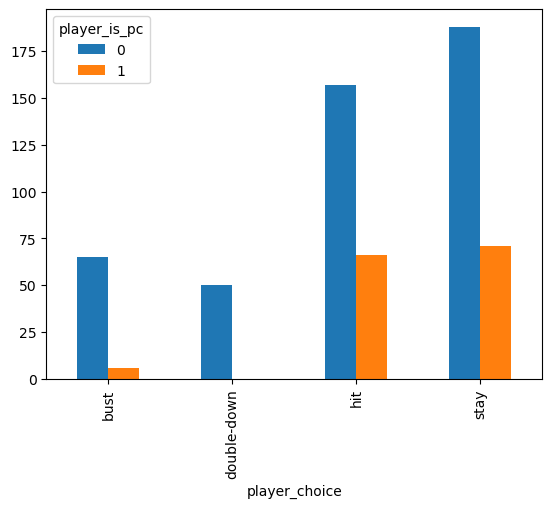

In [5]:
display(dec_grp_df.head(10))
# dec_grp_df.plot.bar(x='player_choice',y='decision_count')
dec_grp_df.pivot(index='player_choice',columns='player_is_pc',values='decision_count').fillna(0).plot.bar()


player_is_pc,0,1
player_choice,,
bust,65,6
hit,207,66
stay,188,71


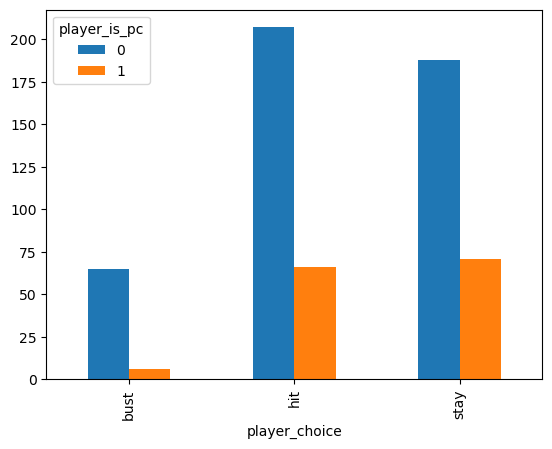

In [6]:
dec_grp_rebase_df = dec_grp_df.copy()
dec_grp_rebase_df['player_choice'] = dec_grp_rebase_df['player_choice'].apply(lambda x: 'hit' if x == 'double-down' else x)
dec_grp_rebase_df = dec_grp_rebase_df.groupby(['player_choice','player_is_pc']).agg(decision_count=('decision_count','sum')).reset_index()
dec_grp_rebase_df.pivot(index='player_choice',columns='player_is_pc',values='decision_count').fillna(0).plot.bar()
display(dec_grp_rebase_df.pivot(index='player_choice',columns='player_is_pc',values='decision_count').head(10))

> **COMMENT**:
>
> When incorporating the `double-down` decision as a `hit` decision, the `hit` vs `stay` decision ratio is very similar between the PC and human player. This is considering that there are two human players and one PC player created by default when running the game, which is what was used when creating this data.
>
> It is glaringly obvious that there is much less bust results from the PC player, when compared to the human players.

### Assigning Wins

This section is particularly important. It is the result of the choices made by the player to see if they had beaten the House.

The result of the below can be used in many different ways (re-inforcement learning, optimization of game play, etc.), and is hence mentioned and handled specifically.

In [7]:
select_cols = ["game_ID","roundNumber","player_name","player_cards","player_choice","player_hand","row_number"]

## Assigning row_number()
hitstay_df = hitstay_df.assign(
        row_number=hitstay_df.sort_index()
        .groupby(["game_ID","roundNumber","player_name"])
        .cumcount()
        + 1)

## Getting final row of each player in that round
hitstay_df['player_final_row'] = hitstay_df.groupby(['game_ID','roundNumber','player_name'])['row_number'].transform('max')
select_cols.append('player_final_row')

## Getting the house final hand
# Step 1: Filter to get the house's final row for each game and round
house_final = hitstay_df.loc[(hitstay_df['player_name'] == 'House') & (hitstay_df['row_number'] == hitstay_df['player_final_row'])]
# Rename the player_hand column to house_final_score
house_final = house_final[['game_ID', 'roundNumber', 'player_hand']].rename(columns={'player_hand': 'house_final_hand'})
# Step 2: Merge this information back to the original dataframe
hitstay_df = hitstay_df.merge(house_final, on=['game_ID', 'roundNumber'], how='left')
select_cols.append('house_final_hand')

## Getting the player result
# Step 1: Filter to get the player's final row for each game and round
player_final = hitstay_df.loc[(hitstay_df['player_name'] != 'House') & (hitstay_df['row_number'] == hitstay_df['player_final_row'])].copy()
player_final['player_result'] = player_final.apply(lambda x: 'Win' if 
                ((x.house_final_hand < x.player_hand) and (x.player_hand <= 21)) or
                ((x.house_final_hand > 21) and (x.player_hand <= 21))
                else 'Draw' if
                ((x.house_final_hand == x.player_hand) and (x.player_hand <= 21))
                else 'Bust' if (x.player_hand > 21) else 'Lost', axis=1)
# # Rename the player_hand column to house_final_score
player_final = player_final[['game_ID', 'roundNumber', 'player_result','player_name']]
# Step 2: Merge this information back to the original dataframe
hitstay_df = hitstay_df.merge(player_final, on=['game_ID', 'roundNumber','player_name'], how='left')

hitstay_df['player_result'] = hitstay_df['player_result'].fillna('NotApplicable')

select_cols.append('player_result')


hitstay_df[select_cols].head(15)

,game_ID,roundNumber,player_name,player_cards,player_choice,player_hand,row_number,player_final_row,house_final_hand,player_result
0,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Joe,"(Di 2,Sp A)",hit,13,1,3,24,Win
1,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Joe,"(Di 2,Sp A,Cl Q)",hit,13,2,3,24,Win
2,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Joe,"(Di 2,Sp A,Cl Q,Cl 5)",stay,18,3,3,24,Win
3,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,"(Hr 2,Sp K)",hit,12,1,2,24,Bust
4,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,"(Hr 2,Sp K,Cl J)",bust,22,2,2,24,Bust
5,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,PC-1,"(Hr 6,Di 9)",hit,15,1,2,24,Win
6,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,PC-1,"(Hr 6,Di 9,Sp 6)",stay,21,2,2,24,Win
7,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,House,"(Sp 4,Hr 7)",hit,11,1,3,24,NotApplicable
8,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,House,"(Sp 4,Hr 7,Cl 3)",hit,14,2,3,24,NotApplicable
9,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,House,"(Sp 4,Hr 7,Cl 3,Sp J)",bust,24,3,3,24,NotApplicable


player_is_pc,0,1
player_result,,
Bust,40,6
Draw,14,6
Lost,40,32
Win,69,44


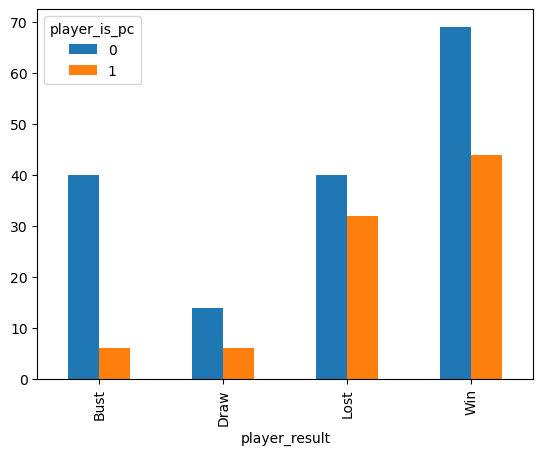

In [8]:
result_grp_df = hitstay_df.loc[hitstay_df.player_name != 'House'].groupby(['game_ID','roundNumber','player_result','player_is_pc']) \
    .agg(decision_count=('player_name','nunique')) \
        .reset_index() \
            .groupby(['player_result','player_is_pc']) \
                .agg(decision_count=('decision_count','sum')) \
                    .reset_index()

result_grp_df.pivot(index='player_result',columns='player_is_pc',values='decision_count').fillna(0).plot.bar()
display(result_grp_df.pivot(index='player_result',columns='player_is_pc',values='decision_count').head(10))

> **COMMENT**:
>
> From the above it seems as though the Win and Lost proportioin of both the Human and PC players are very similar. However, it is glaringly obvious that the Bust percentage is much higher

## Data manipulation

In this section, the data to be used for classification is worked with.

The relevent data to this classification problem is:
1. `player_bet`
2. `player_cards`
3. `house_visible_card`

Initially, the classification was only binary ('**stay**' or '**hit**'), however with the addition of the '**double-down**' option, this became a multi-class problem (at least for the first decision).

I would still like to build this as a binary-classification, and use logistic regression as a base model. The reason for logisitic regression is, I would like to build the model from first principles. Then I would like to build a NN, and lastly I will include other multi-class classifiers from sklearn.

The data would be done a bit different for each step, and that is fine for then. For now only focus on the binary classification and swop the '**double-down**' option for a normal '**hit**' option.

In order to train "*good*" behavior, I will test and see if it will work to treat the pen-ultimate decision as '`stay`' if the ultimate result was a '`bust`'.

> ***NOTE***:
> 
> For the first part I will exclude the `House` from the dataset. The behavior in the logging is different for `House`. There can be a separate model developed solely for the `House`

In [9]:
select_cols = ['player_hand','house_visible_hand','house_card','player_bet','player_cards']

players_df = hitstay_df.loc[hitstay_df.player_name != 'House'].copy()
players_df['house_card'] = players_df.house_visible_card.str.split().str[1]

_, card_col_no = players_df.player_cards.str.replace("(","").str.replace(")","").str.split(",",expand=True).shape
card_cols = [f"card_{i+1}" for i in np.arange(card_col_no)]
select_cols.extend(card_cols)

players_df[card_cols] = players_df.player_cards.str.replace("(","").str.replace(")","").str.split(",",expand=True)
for col in card_cols:
    players_df[col] = players_df[col].str.split().str[1]

## Not sure if 0 is better than None. I think None will help a bit more...
# players_df[card_cols] = players_df[card_cols].fillna(value=0)

players_df[select_cols].head()

,player_hand,house_visible_hand,house_card,player_bet,player_cards,card_1,card_2,card_3,card_4,card_5
0,13,7,7,70.0,"(Di 2,Sp A)",2,A,None,None,None
1,13,7,7,70.0,"(Di 2,Sp A,Cl Q)",2,A,Q,None,None
2,18,7,7,70.0,"(Di 2,Sp A,Cl Q,Cl 5)",2,A,Q,5,None
3,12,7,7,70.0,"(Hr 2,Sp K)",2,K,None,None,None
4,22,7,7,70.0,"(Hr 2,Sp K,Cl J)",2,K,J,None,None


### Dummy columns

Dummy variables are created based on the player's cards

In [10]:
def check_and_order_columns(df,ordered_list):
    df_cols = df.columns; df_rows, _ = df.shape
    mis_cols = [c for c in ordered_list if c not in df_cols]
    if len(mis_cols) > 0:
        for mc in mis_cols:
            df[mc] = np.zeros(df_rows).astype(int)
    return (mis_cols, df[ordered_list].copy())

def create_addative_dummy_matrix(df,columns_to_dummy,dummy_columns):
    ret_df = pd.get_dummies(df[columns_to_dummy[0]]).astype(int)
    for col in columns_to_dummy[1:]:
        ret_df = ret_df.add(pd.get_dummies(df[col]),fill_value=0).astype(int)
    mis_cols,ret_df = check_and_order_columns(ret_df,dummy_columns)
    return (mis_cols,ret_df)

In [11]:
dummy_columns = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']
mis_dummy_cols, dummy_df = create_addative_dummy_matrix(df=players_df, columns_to_dummy=card_cols,dummy_columns=dummy_columns)

## Adding the house_visible_card in
dummy_df = dummy_df.add(pd.get_dummies(players_df.house_card).astype(int)*-0.5, fill_value=0)
mis_dummy_cols_2, dummy_df = check_and_order_columns(dummy_df,dummy_columns)

print(f"dummy_df [{dummy_df.shape=}] ({mis_dummy_cols=}) ({mis_dummy_cols_2=})")
display(dummy_df.head())

dummy_df [dummy_df.shape=(428, 13)] (mis_dummy_cols=[]) (mis_dummy_cols_2=[])


,2,3,4,5,6,7,8,9,10,J,Q,K,A
0,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,-0.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [12]:
## Just checking the additions
dummy_df.join(players_df[['house_card','player_cards',*card_cols]],how='left').head()

,2,3,4,5,6,7,8,9,10,J,Q,K,A,house_card,player_cards,card_1,card_2,card_3,card_4,card_5
0,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,"(Di 2,Sp A)",2,A,None,None,None
1,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,7,"(Di 2,Sp A,Cl Q)",2,A,Q,None,None
2,1.0,0.0,0.0,1.0,0.0,-0.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,7,"(Di 2,Sp A,Cl Q,Cl 5)",2,A,Q,5,None
3,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7,"(Hr 2,Sp K)",2,K,None,None,None
4,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,7,"(Hr 2,Sp K,Cl J)",2,K,J,None,None


### Normalize player bet

The above dummy features have a small scale. I need to normalize (standardize according to sklearn) `player_bet` in order to not have the magnitude influence the decision immensely.

There is going to be leakage in the way that I am going to apply it, however it is allowable, since the assumption is that all bets will be drawn from the same distribution, irrespective of when it is made.

,player_bet,player_bet_norm
count,428.000000,4.280000e+02
mean,113.815421,-7.885696e-17
std,66.517530,1.000000e+00
min,50.000000,-9.593775e-01
25%,70.000000,-6.587049e-01
50%,100.000000,-2.076959e-01
75%,150.000000,5.439856e-01
max,450.000000,5.054075e+00


<Axes: ylabel='Frequency'>

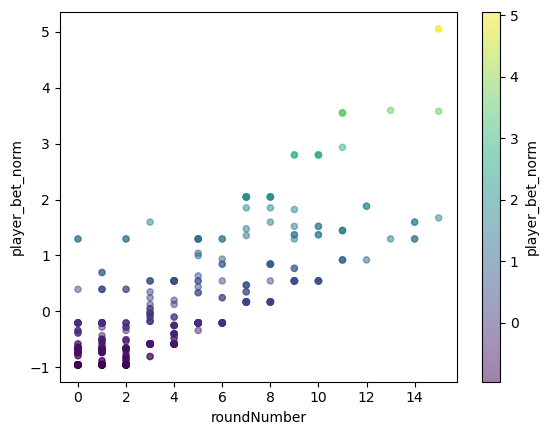

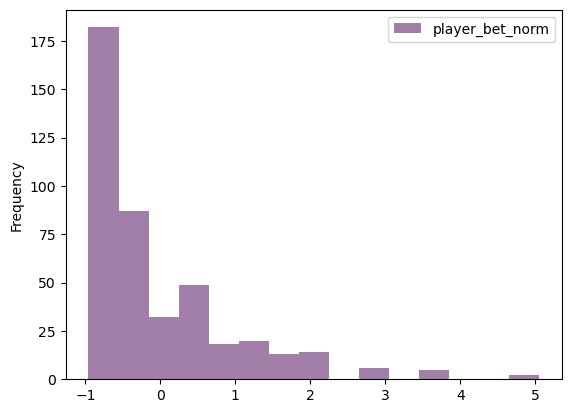

In [13]:
players_df['player_bet_norm'] = (players_df.player_bet - players_df.player_bet.mean())/players_df.player_bet.std()
# players_df[['player_bet','player_bet_norm']].head(20)
display(players_df[['player_bet','player_bet_norm']].describe())
players_df.plot.scatter(y='player_bet_norm',x='roundNumber',c='player_bet_norm',colormap='viridis',alpha=0.5)
players_df.plot.hist(column='player_bet_norm',bins=15,colormap='viridis',alpha=0.5)

In [14]:
players_df.head(10)

,game_ID,roundNumber,player_name,player_is_pc,round_initial_bet,player_bet,game_pot,player_cards,player_hand,player_bust,...,player_final_row,house_final_hand,player_result,house_card,card_1,card_2,card_3,card_4,card_5,player_bet_norm
0,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Joe,0,50.0,70.0,70,"(Di 2,Sp A)",13,0,...,3,24,Win,7,2,A,None,None,None,-0.658705
1,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Joe,0,50.0,70.0,70,"(Di 2,Sp A,Cl Q)",13,0,...,3,24,Win,7,2,A,Q,None,None,-0.658705
2,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Joe,0,50.0,70.0,70,"(Di 2,Sp A,Cl Q,Cl 5)",18,0,...,3,24,Win,7,2,A,Q,5,None,-0.658705
3,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,0,50.0,70.0,140,"(Hr 2,Sp K)",12,0,...,2,24,Bust,7,2,K,None,None,None,-0.658705
4,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,0,50.0,70.0,140,"(Hr 2,Sp K,Cl J)",22,1,...,2,24,Bust,7,2,K,J,None,None,-0.658705
5,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,PC-1,1,50.0,75.0,215,"(Hr 6,Di 9)",15,0,...,2,24,Win,7,6,9,None,None,None,-0.583537
6,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,PC-1,1,50.0,75.0,215,"(Hr 6,Di 9,Sp 6)",21,0,...,2,24,Win,7,6,9,6,None,None,-0.583537
10,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Joe,0,50.0,50.0,50,"(Cl 10,Hr 6)",16,0,...,1,21,Lost,A,10,6,None,None,None,-0.959377
11,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Albert,0,50.0,50.0,100,"(Cl A,Sp 3)",14,0,...,2,21,Draw,A,A,3,None,None,None,-0.959377
12,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Albert,0,50.0,100.0,100,"(Cl A,Sp 3,Cl 7)",21,0,...,2,21,Draw,A,A,3,7,None,None,-0.207696


## Creating the training set

In order to not allow data leakage, there are only three variables that can be incorporated into each `hit`/`stay` decision:
1. Visible House card 
2. Current players cards
3. Current players amount that has been bet

These are discussed below.

### Dealt Cards (1) and (2)

In the above section, both (1) and (2) have been represented as a vector which shows the current players cards as integers, and the visible house card as a negative double. For the current model this is deemed to be an adequate representation of this part of the feature space.

The above mechanics portray what needs to be done to enable this.

### Current players bet (3) 

There are a number of ways to represent this data:
1. As a stand-alone column, or element in the existing vector. This needs to be normalized/standardized due to the magnitude difference in the vector representation of the cards.
2. It can be used a scaler multiplier for the card representation. This can be done with either the actual value, or the normalized value due to it being applied equaly across the vector representation.

## Creating the label

There are two ways in which I can handle working with the '**bust**' decisions:
1. Simply remove the '**bust**' decisions
2. Remove any '**bust**' "*decision*"s and turn the previous ones into '**stay**' decisions

Since this is a game of chance, applying (1) probably makes more sense. However, in the interest of training a model to make the best decisions (2) also carries some weight.


## Initial implementation

For the initial implementation of the training set, the following decisions are made:
1. Dealt cards - this is deemed as sufficient and will be used as is
2. Players bet - this will be ignored for the initial implementation
3. Labels - simply removing the bust decisions for now


This means that the complete initial training set is the `dummy_df` with the decision lables excluding the `bust` decisions.

In [15]:
pre_train_df = dummy_df.join(hitstay_df[['player_choice','player_name']]).copy()
train_df = pre_train_df.loc[(pre_train_df.player_choice != 'bust') & (pre_train_df.player_name != 'House')].drop('player_name',axis=1)
## transforming the label to a 0,1. (hit ==1, stay == 0)
train_df['player_choice'] = (train_df['player_choice'] == 'hit').astype(int)
print(f"{train_df.shape=}")
train_df.head()

train_df.shape=(382, 14)


,2,3,4,5,6,7,8,9,10,J,Q,K,A,player_choice
0,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
2,1.0,0.0,0.0,1.0,0.0,-0.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
3,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
5,0.0,0.0,0.0,0.0,1.0,-0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [16]:
X_df = train_df.drop('player_choice',axis=1)
y_df = train_df['player_choice']

In [17]:
test_size = 0.4; rand_state = 42
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_size, random_state=rand_state)

print(f"{X_df.shape=}\n{y_df.shape=}\n Class imbalance= {np.sum(y_df)/(y_df.shape[0]):.3f}\n\n{X_train.shape=}\n{y_train.shape=}")
print(f" Class imbalance= {np.sum(y_train)/(y_train.shape[0]):.3f}\n\n{X_test.shape=}\n{y_test.shape=}\n Class imbalance= {np.sum(y_test)/(y_test.shape[0]):.3f}")

X_df.shape=(382, 13)
y_df.shape=(382,)
 Class imbalance= 0.361

X_train.shape=(229, 13)
y_train.shape=(229,)
 Class imbalance= 0.415

X_test.shape=(153, 13)
y_test.shape=(153,)
 Class imbalance= 0.281


# Logistic regression

This is the part where logistic regression is implement from scratch.

Logistic Regression I have learned about and used many times before, but to be honest I have only used it through packages and more specifically through `R`s `glm` package. So the internals of how the updating of the model parameters happens has always been abstracted away.

I asked ChatGPT to explain, how to think about implementing logistic regression from scratch. It produced a very detailed response which included a fully written class that implemented the ideas. I was amazed (and shocked), so I needed to verify the explanation and the code. I sought out some education material (other than ChatGPT), and created the write up written below.

> ***NOTE***:
>
>I found the [IBM developer website on logistic regression](https://developer.ibm.com/articles/implementing-logistic-regression-from-scratch-in-python/) to be extremely helpful. It also had a link to this [Stanford.edu pdf on logistic regression](https://web.stanford.edu/~jurafsky/slp3/5.pdf) which helped me understand the derivation of the `W`
>
> Additionally the [Stanford.edu pdf](https://web.stanford.edu/~jurafsky/slp3/5.pdf) also discussed the multiclass logistic regression (a.k.a. *multinomial regression*), which is something that I find interesting.

## The math

To implement logistic regression, you first need to know a couple of basics:

1. What is the logistic function?
2. Which loss function do you use?
3. How do you update your model given your loss?

(1) I knew about, but (2) and (3) I was unclear on how they fit together.

### 1. What is the logistic function?

The logistic function is the link function that takes the linear combination of the input and the model weights (`w`) and transforms them into the $(0,1)$ space.

There are a few link functions, but in this example I will use the sigmoid which is the generally used link function. The sigmoid is formulated as:

$$
\begin{align}
\sigma(z) = \frac{1}{1+e^{-z}}
\end{align}
$$

where $z = \beta x$, with $x$ as your input vector, and $\beta$ your model parameters.

#### Derivative of $\sigma(z)$
An interesting side note is that the first order derivative of the $\sigma(z)$ is $\frac{d\sigma(z)}{dz} = \sigma(z)(1-\sigma(z))$.

This may come in handy later.

### 2. Which loss function do you use?

In linear regression, you use the simple least squares. However for logistic regression $y \in \{0,1\}$, which means that if you use the least squares loss you may get stuck in local minima pergatory.

For logistic regression we use cross entropy loss:

$$
L_{(CE)} = - \frac{1}{m}\sum_{i=1}^{m}y\text{log}(\hat{y}) + (1 - y)\text{log}(1-\hat{y}) \tag{2}
$$

This means that for $y=1$, the first part of the equation applies, while when $y=0$ the second part applies. It is also important to note that $\hat{y}$ refers to the result from the sigmoid function (i.e. a value $\in (0,1)$ not the transformed result of $0$ or $1$).

#### Derivative of $L_{(CE)}$

For this you will need to calculate the partial derivative of $L_{(CE)}$ with respect to $\beta$.

$\beta$ can be formulated as a vector split up in two parts: $\beta_0$ and $\beta_{\text{remaining}}$ which can also be written as:

$$
\begin{align}
\beta_0 &= b \text{ (a.k.a. bias)} \tag{3}\\
\beta_{\text{remaining}} &= w \text{ (a.k.a. weights)} \tag{4}
\end{align}
$$

From this the partial derivatives are:

$$
\begin{align}
\frac{\partial{L_{(CE)}(\hat{y},y)}}{\partial{w}} &= \frac{1}{m}(\hat{y}-y)x_i^T \tag{5}\\
\frac{\partial{L_{(CE)}(\hat{y},y)}}{\partial{b}} &= \frac{1}{m}(\hat{y}-y) \tag{6}
\end{align}
$$

The above derivations I am merely using from the [IBM post](https://developer.ibm.com/articles/implementing-logistic-regression-from-scratch-in-python/).

This formulation could however be simplified to a single equation, by simply collapsing $\beta$ into a single vector of weights. I.e. when inspecting equation $(6)$ above, you can see that it can be rewritten as:

$$
\begin{align}
\frac{\partial{L_{(CE)}(\hat{y},y)}}{\partial{b}} &= \frac{1}{m}(\hat{y}-y) \times 1 \tag{7}
\end{align}
$$

If you simply add a column of $1$'s to your $X$, it will achieve the same, while only having a single derivative to compute each time. This derivative will therefore have the same for as equation $(5)$.

### 3. How do you update your model given your loss?

In general, the loss function has two main functions given when training your model:

1. *Calculating the loss* - this measure the error of the models predictions. If tracked over time (while training the model), it shows the convergance of training when decreasing, or divergence otherwise.
2. *Calculating the derivative for parameter updating* - this is a function of the **derivative of the loss**. The loss itself does not influence the parameters directly, but rather its derivative calculates the amount of adjusting each parameter.

(2) is achieved by applying the gradient descent technique. It is an optimization method where the gradient of the loss function is calculated at a given point given the model parameters and the data itself. Then a step is taken in the opposite direction than the gradient.

## Implementation

> ***NOTE***:
>
> A class is included which implements the ideas taken above (`logisticRegression.py`). This implementation is a slightly amended output from ChatGPT, which generated the original script.
>
> Both the prompt and the generation is included in a separate `.md`-file. 
>> ***PS***:
>>
>> I went down the math rabbit-whole because I wanted to check if the implementation was correct. It is. That is really crazy!

In [18]:
def calculate_classification_metrics(y_true,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return {"accuracy":accuracy,"f1":f1,"precision":precision,"recall":recall}

def create_performance_table(y_true,y_proba,thresholds):
    stg_table = []
    for th in thresholds:
        y_preds = [1 if i > th else 0 for i in y_proba]
        metrics_dict = calculate_classification_metrics(y_true,y_preds)
        stg_table.append({"threshold":th,**metrics_dict})
    perf_df = pd.DataFrame(stg_table)
    return perf_df

In [19]:
from logisticRegression import LogisticRegression

model = LogisticRegression()
model.fit(X_train,y_train)


Loss after iteration    0: 0.6931
Loss after iteration  100: 0.6230
Loss after iteration  200: 0.6061
Loss after iteration  300: 0.5982
Loss after iteration  400: 0.5931
Loss after iteration  500: 0.5891
Loss after iteration  600: 0.5856
Loss after iteration  700: 0.5826
Loss after iteration  800: 0.5799
Loss after iteration  900: 0.5774
Loss after FINAL iteration: 0.5752 (iterations=  1000)


In [20]:
pred_probs = model.predict(X_test)

loss = model.compute_loss(y=y_test.to_numpy(),y_hat=pred_probs)
print(f"The test loss is: {loss:.4f}")

The test loss is: 0.5599


,threshold,accuracy,f1,precision,recall
0,0.2,0.444444,0.491018,0.330645,0.953488
1,0.3,0.535948,0.503497,0.360000,0.837209
2,0.4,0.653595,0.554622,0.434211,0.767442
3,0.5,0.725490,0.511628,0.511628,0.511628
4,0.6,0.732026,0.388060,0.541667,0.302326
5,0.7,0.725490,0.192308,0.555556,0.116279


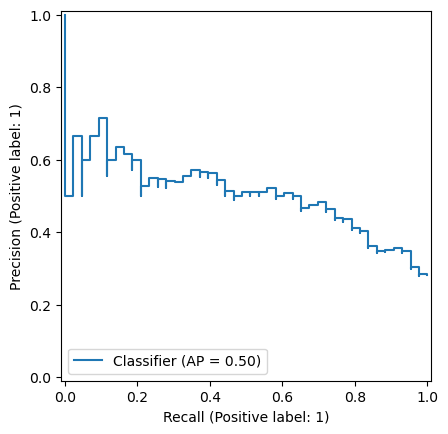

In [21]:
performance_df = create_performance_table(y_test.to_numpy(),pred_probs,[0.2,0.3,0.4,0.5,0.6,0.7])
display(performance_df)

PrecisionRecallDisplay.from_predictions(y_test, pred_probs)
plt.show()


# Neural Network

This is a simple NN which will complete a binary classification.

It is an extention on the regression NN, however at the final layer it is using a `sigmoid()`.

In [22]:
## Lets determine if we can run on `cuda`-device

device = "cpu"
if tc.cuda.is_available():
    device = 'cuda'

print(f"Device is: {device}")

Device is: cpu


In [23]:
# ## Defining a class for the NeuralNet
# class LinearSequentialNeuralNet(tc.nn.Module):
#     def __init__(self,in_vec_size=[13],layers=[13,13,1],act_func=tc.nn.ReLU()):
#         super().__init__()
#         nn_layers = in_vec_size; nn_layers.extend(layers)
#         fnn_layers = [nn_layers[i:(i+2)] for i in np.arange(len(nn_layers)-1)]
#         fnn_layers = [[tc.nn.Linear(i,j),act_func] for i,j in fnn_layers]
#         fnn_layers = [item for el in fnn_layers for item in el]

#         self.linear_layers_stack =  tc.nn.Sequential(
#             *fnn_layers[:-1]
#         )

#     def forward(self,X):
#         logits = self.linear_layers_stack(X)
#         return logits


In [24]:
class LinearSequentialNeuralNet(tc.nn.Module):
    def __init__(self, in_vec_size=13, layers=[13, 13, 1], act_func=tc.nn.ReLU()):
        super().__init__()
        nn_layers = [in_vec_size] + layers
        fnn_layers = []
        for i in range(len(nn_layers) - 1):
            fnn_layers.append(tc.nn.Linear(nn_layers[i], nn_layers[i+1]))
            if i < len(nn_layers) - 2:  # Don't add activation after the last layer
                fnn_layers.append(act_func)
        
        # Add sigmoid activation at the end for binary classification
        fnn_layers.append(tc.nn.Sigmoid())

        self.linear_layers_stack = tc.nn.Sequential(*fnn_layers)

    def forward(self, X):
        return self.linear_layers_stack(X)

# Create the model
model = LinearSequentialNeuralNet(in_vec_size=13, layers=[13, 13, 1])

# Use Binary Cross Entropy Loss
loss_func = tc.nn.BCELoss()

# Create optimizer
optimizer = tc.optim.Adam(model.parameters(), lr=0.001)

print(model)

LinearSequentialNeuralNet(
  (linear_layers_stack): Sequential(
    (0): Linear(in_features=13, out_features=13, bias=True)
    (1): ReLU()
    (2): Linear(in_features=13, out_features=13, bias=True)
    (3): ReLU()
    (4): Linear(in_features=13, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [25]:
# in_vector = [13]
# layers = [13,13,1] # [60,60,60,60,1] # [8,4,8,13,1]

# model = LinearSequentialNeuralNet(in_vec_size=in_vector,layers=layers)#.to(device)

# loss_func = tc.nn.CrossEntropyLoss()
# optimizer = tc.optim.SGD(model.parameters(),lr=1e-1)

# print(f"model: \n{model}\n\n loss: {loss_func}\n optm:\n {optimizer}")

In [26]:
## Data -  Convert to 2D PyTorch tensors
X_train_tc = tc.tensor(X_train.values, dtype=tc.float32)
y_train_tc = tc.tensor(y_train.values, dtype=tc.float32).reshape(-1, 1)
X_test_tc = tc.tensor(X_test.values, dtype=tc.float32)
y_test_tc = tc.tensor(y_test.values, dtype=tc.float32).reshape(-1, 1)


## Experiment settings
n_epochs = 100
batch_size = 20
batch_start = tc.arange(0, len(X_train_tc), batch_size)
learning_rate = 0.1


 # Hold the best model
best_acc = - np.inf   # init to negative infinity
best_weights = None
acc_hist = []
loss_hist = []


In [27]:
## Just checking if the model code is working properly...
logits = model(X_train_tc)
pred_probs = tc.nn.Sigmoid()(logits)
y_pred = pred_probs.argmax(1)
print(f"y_pred ({y_pred.shape}): {y_pred[:5]}")

y_pred (torch.Size([229])): tensor([0, 0, 0, 0, 0])


In [28]:
def train_loop(X_train, y_train, train_batch_size, model, loss_func, optimizer):
    full_size, _ = X_train.shape
    check_size, _ = y_train.shape
    assert full_size == check_size, "X_train and y_train not equal number of observations"
    batch_number = np.ceil(float(full_size)/train_batch_size)
    
    model.train()
    for i in np.arange(batch_number):
        X = X_train[int(i)*train_batch_size:int(i+1)*train_batch_size]
        y = y_train[int(i)*train_batch_size:int(i+1)*train_batch_size]

        y_hat = model(X)

        loss = loss_func(y_hat, y)

        loss.backward()
        
        # Print gradient norm
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.detach().data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        print(f"Gradient norm: {total_norm}")

        optimizer.step()
        optimizer.zero_grad()

        print(f"train_{i:.1f}: loss = {loss.item():>.3f} [{train_batch_size*i:>.3f}/{full_size:>.3f}]")

In [29]:
# def train_loop(X_train, y_train, train_batch_size, model, loss_func, optimizer):
#     full_size, _ = X_train.shape
#     check_size = y_train.shape[0]
#     assert full_size == check_size, "X_train and y_train not equal number of observations"
#     batch_number = tc.ceil(tc.tensor(float(full_size)/train_batch_size)).int()
    
#     model.train()
#     for i in range(batch_number):
#         start_idx = int(i * train_batch_size)
#         end_idx = int((i + 1) * train_batch_size)
#         X = X_train[start_idx:end_idx]
#         y = y_train[start_idx:end_idx]

#         print("X dtype:", X.dtype)
#         print("y dtype:", y.dtype)
#         print("X shape:", X.shape)
#         print("y shape:", y.shape)
#         print("X sample:", X[:5])
#         print("y sample:", y[:5])

#         y_hat = model(X)

#         print("y_hat shape:", y_hat.shape)
#         print("y_hat sample:", y_hat[:5])

#         try:
#             loss = loss_func(y_hat, y)
#             print(f"Loss from loss_func: {loss.item()}")

#             # Manual loss calculation
#             if isinstance(loss_func, tc.nn.MSELoss):
#                 manual_loss = ((y_hat - y) ** 2).mean()
#             elif isinstance(loss_func, tc.nn.CrossEntropyLoss):
#                 # Ensure y is long tensor and has the correct shape
#                 y_long = y.long().view(-1)
#                 manual_loss = -tc.nn.functional.log_softmax(y_hat, dim=1)[range(y_hat.shape[0]), y_long].mean()
#             else:
#                 manual_loss = tc.tensor(0.0)  # Placeholder for other loss functions
#             print(f"Manual loss: {manual_loss.item()}")

#             loss.backward()
            
#             total_norm = 0
#             for name, param in model.named_parameters():
#                 if param.grad is not None:
#                     param_norm = param.grad.data.norm(2)
#                     total_norm += param_norm.item() ** 2
#                     print(f"Gradient norm for {name}: {param_norm:.4f}")
#             total_norm = total_norm ** 0.5
#             print(f"Total gradient norm: {total_norm:.4f}")

#             optimizer.step()
#             optimizer.zero_grad()

#         except Exception as e:
#             print("Error occurred:", str(e))
#             print("Error type:", type(e).__name__)
#             import traceback
#             traceback.print_exc()
        
#         print(f"train_{i}: loss = {loss.item():>.6f} [{train_batch_size*i:>.3f}/{full_size:>.3f}]")
#         print("-------------------------------")

In [30]:
# def train_loop(X_train, y_train, train_batch_size, model, loss_func, optimizer):
#     full_size = X_train.shape[0]
#     check_size = y_train.shape[0]
#     assert full_size == check_size, "X_train and y_train not equal number of observations"
#     batch_number = int(np.ceil(float(full_size)/train_batch_size))
    
#     model.train()
#     for i in range(batch_number):
#         start_idx = int(i * train_batch_size)
#         end_idx = int(min((i + 1) * train_batch_size, full_size))
#         X = X_train[start_idx:end_idx]
#         y = y_train[start_idx:end_idx]

#         print(f"Batch {i+1}/{batch_number}")
#         print("X shape:", X.shape)
#         print("y shape:", y.shape)

#         y_hat = model(X)

#         print("y_hat shape:", y_hat.shape)
#         print("y_hat sample:", y_hat[:5].detach().numpy())
#         print("y sample:", y[:5].detach().numpy())

#         try:
#             # Ensure y is the correct shape
#             y = y.view(-1, 1).float()
            
#             loss = loss_func(y_hat, y)
#             print(f"Loss: {loss.item():.6f}")

#             loss.backward()
            
#             total_norm = 0
#             for name, param in model.named_parameters():
#                 if param.grad is not None:
#                     param_norm = param.grad.data.norm(2)
#                     total_norm += param_norm.item() ** 2
#                     print(f"Gradient norm for {name}: {param_norm:.4f}")
#             total_norm = total_norm ** 0.5
#             print(f"Total gradient norm: {total_norm:.4f}")

#             optimizer.step()
#             optimizer.zero_grad()

#         except Exception as e:
#             print("Error occurred:", str(e))
#             print("Error type:", type(e).__name__)
#             import traceback
#             traceback.print_exc()
        
#         print(f"train_{i}: loss = {loss.item():>.6f} [{end_idx:>.0f}/{full_size:>.0f}]")
#         print("-------------------------------")

# # Run the training loop
# # train_loop(X_train, y_train, batch_size, model, loss_func, optimizer)

In [31]:

def test_loop(X,y,model,loss_func):
    test_size,_ = X.shape
    y_size,_ = y.shape
    assert test_size == y_size, "X_test and y_test not equal number of observations"

    ## Evaluation cycle
    model.eval()
    test_loss, correct = 0, 0

    with tc.no_grad():
        y_hat = model(X)
        test_loss += loss_func(y_hat, y).item()
        correct += (y_hat.argmax(1) == y).type(tc.float).sum().item()

    test_loss /= y_size
    correct /= y_size
    print(f"Test error: \n Accuracy: {100*correct:>0.1f} Avg loss: {test_loss:>8f} \n")       

    

In [32]:

epochs = 10
stg_weights = np.zeros(len(list(model.parameters())[1]))
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(X_train_tc,y_train_tc,batch_size, model, loss_func, optimizer)
    test_loop(X_test_tc, y_test_tc, model, loss_func)
    print("\n")
    prev_weights = stg_weights
    stg_weights = list(model.parameters())[1].detach().numpy()
    print(f"ReLU params (no changes={np.sum(prev_weights != stg_weights)})\n\t {stg_weights}")
print("Done!")

Epoch 1
-------------------------------
Gradient norm: 0.06514316775654622
train_0.0: loss = 0.700 [0.000/229.000]
Gradient norm: 0.31743574576813605
train_1.0: loss = 0.642 [20.000/229.000]
Gradient norm: 0.05750167256916702
train_2.0: loss = 0.690 [40.000/229.000]
Gradient norm: 0.09124808130263586
train_3.0: loss = 0.680 [60.000/229.000]
Gradient norm: 0.12723054401129769
train_4.0: loss = 0.708 [80.000/229.000]
Gradient norm: 0.03423203663194363
train_5.0: loss = 0.687 [100.000/229.000]
Gradient norm: 0.1411335151243641
train_6.0: loss = 0.704 [120.000/229.000]
Gradient norm: 0.07951048790795047
train_7.0: loss = 0.701 [140.000/229.000]
Gradient norm: 0.08688598562575149
train_8.0: loss = 0.673 [160.000/229.000]
Gradient norm: 0.3252524581373036
train_9.0: loss = 0.642 [180.000/229.000]
Gradient norm: 0.04128659448124824
train_10.0: loss = 0.684 [200.000/229.000]
Gradient norm: 0.2943414968107935
train_11.0: loss = 0.645 [220.000/229.000]
Test error: 
 Accuracy: 11000.0 Avg loss: 0

In [33]:
y_hat = model(X_test_tc)
pd.DataFrame(y_hat.detach().numpy()).describe()

,0
count,153.000000
mean,0.414773
std,0.016181
min,0.372843
25%,0.402557
50%,0.415979
75%,0.425588
max,0.450886


In [34]:
y_test_tc[:5]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

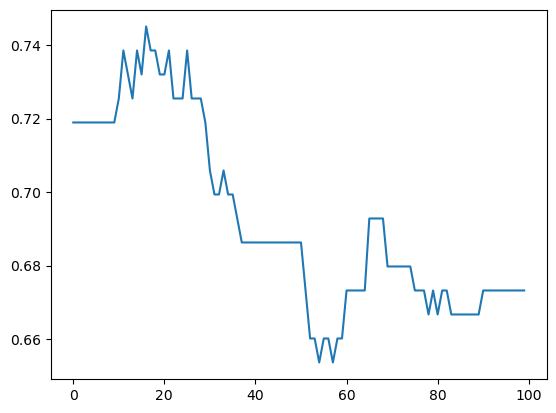

In [35]:
# acc_hist = []; loss_hist = []
# for epoch in range(n_epochs):
#     model.train()
#     with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
#         bar.set_description(f"Epoch {epoch}")
#         for start in bar:
#             # take a batch
#             X_batch = X_train_tc[start:start+batch_size]
#             y_batch = y_train_tc[start:start+batch_size]
#             # forward pass
#             y_pred = model(X_batch)
#             loss = loss_func(y_pred, y_batch)
#             # backward pass
#             optimizer.zero_grad()
#             loss.backward()
#             # update weights
#             optimizer.step()
#             # print progress
#             acc = (y_pred.round() == y_batch).float().mean().numpy()
#             bar.set_postfix(
#                 loss=float(loss),
#                 acc=float(acc)
#             )
#     # evaluate accuracy at end of each epoch
#     model.eval()
#     y_pred = model(X_test_tc)
#     loss = loss_func(y_pred,y_test_tc)
#     acc = (y_pred.round() == y_test_tc).float().mean()
#     acc = float(acc)
#     acc_hist.append(acc)
#     loss_hist.append(loss)
#     if acc > best_acc:
#         best_acc = acc
#         best_weights = copy.deepcopy(model.state_dict())
# restore model and return best accuracy
# model.load_state_dict(best_weights)
# # print(history)
# plt.plot(acc_hist)
# plt.show()

# Conclusion

I am settling on the Logistic regression, for this. It seems as though it is performing better than the NN (though it may be due to me not knowing enough to get the NN working)

Will get back to this project at a later stage.